<a href="https://colab.research.google.com/github/ElizabethGhi/tools-for-remote-sensing-data-analysis/blob/main/Conversion_shp_to_nc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.3 MB/s eta 0:00:00


In [2]:
!pip install PyCRS

  Preparing metadata (setup.py) ... done
  Created wheel for PyCRS: filename=PyCRS-1.0.2-py3-none-any.whl size=32687 sha256=44a854a7f2646bd1439d5945aaa2cf6e2b2fa33f6cff6331b99440c5a36061a1
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built PyCRS


In [3]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.3 MB/s eta 0:00:00


In [20]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import rasterio.transform
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geemap
import os
from shapely.ops import unary_union

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
# IMPORTAR SHAPES DEL AREA DE ESTUDIO
path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/SHP_CM"
Poligonos = os.path.join(path, "Poligonos.shp")   #Basin_Mexico = os.path.join(path, "Basin_of_Mexico.shp")

gdf_Poligonos = gpd.read_file(Poligonos) #Convertir shp a df

In [6]:
gdf_Poligonos.head(8)

,CLV_EDO,NOM_EDO,CLV_REGION,NOM_REGION,CLV_ACUI,DISP_2010,CLAVE,ACUIFERO,R,DNCOM,VCAS,VEXTET,DAS,DEFICIT,DEFICIT_MI,SobreExplo,geometry
0,15,MEXICO,13,VALLE DE MEXICO,1507,-49.0734,1507,TEXCOCO,161.0,10.4,246.057911,184.2,0.000000,-95.457911,-95.457911,s,"POLYGON ((-98.77808 19.59044, -98.69309 19.575..."
1,13,HIDALGO,13,VALLE DE MEXICO,1319,26.4216,1319,TECOCOMULCO,27.8,0.5,1.193658,13.1,26.086342,0.000000,26.106342,n,"POLYGON ((-98.39443 19.97261, -98.39389 19.971..."
2,9,DISTRITO FEDERAL,13,VALLE DE MEXICO,0901,-713.6292,0901,ZONA METROPOLITANA DE LA CD. DE MÉ...,512.8,0.0,"1,103.463415",623.8,0.000000,-590.663415,-590.663415,s,"POLYGON ((-99.26703 19.59501, -99.26629 19.594..."
3,13,HIDALGO,13,VALLE DE MEXICO,1320,58.9843,1320,ÁPAN,30.3,0.0,18.014599,14.8,12.285401,0.000000,12.285401,n,"POLYGON ((-98.29837 19.78654, -98.2368 19.7575..."
4,29,TLAXCALA,13,VALLE DE MEXICO,2902,33.5249,2902,SOLTEPEC,92.8,42.0,16.259322,18.3,34.540678,0.000000,34.540678,n,"POLYGON ((-98.22678 19.72651, -98.22633 19.726..."
5,15,MEXICO,13,VALLE DE MEXICO,1506,-16.4022,1506,CHALCO - AMECAMECA,79.3,3.3,97.613894,128.4,0.000000,-21.613894,-21.613894,s,"POLYGON ((-98.70982 19.33596, -98.70979 19.335..."
6,15,MEXICO,13,VALLE DE MEXICO,1508,-189.9915,1508,CUAUTITLÁN - PACHUCA,356.7,0.0,412.295070,751.3,0.000000,-55.59507,-55.595070,s,"POLYGON ((-98.73432 20.18883, -98.73374 20.188..."


# GENERAR POLIGONO EXTERIOR EN FORMATO .nc

In [ ]:
#RASTERIZAR
# Definir la resolución y los límites de la cuadrícula
bounds = gdf_Poligonos.total_bounds  # Devuelve una lista con los valores extremos de la extensión total del shapefile [minx, miny, maxx, maxy]
resolution = 0.001

# Crear una cuadrícula vacía
out_shape = (
    int((bounds[3] - bounds[1]) / resolution),  #Devuelve el número de filas. Bounds[3]=maxy, bounds[1] = miny
    int((bounds[2] - bounds[0]) / resolution)   # Devuelve el número de columnas. Bounds[2]=maxx, bounds[0] = minx
)
transform = rasterio.transform.from_bounds(*bounds, out_shape[1], out_shape[0])

# Rasterizar el shapefile
rasterized = rasterize(
    [(geom, 1) for geom in gdf_Poligonos.geometry],
    out_shape=out_shape,
    transform=transform,
    fill=0,  # Establecer ceros fuera del raster
    dtype='float32'
)

In [ ]:
#Generar NetCDF con los valores del raster
da = xr.DataArray(
    rasterized,
    dims=("lat", "lon"),
    coords={
        "lat": np.linspace(bounds[3], bounds[1], rasterized.shape[0]),
        "lon": np.linspace(bounds[0], bounds[2], rasterized.shape[1]),
    },
    name='Poligonos'  # Nombre del array
)

# Crear un dataset del xarray y la variable 'CM' (Cuenca de Mexico)
ds = xr.Dataset({'CM': da})

# Guardar archivo NetCDF
outhpath = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/NetCDF_CM/Poligono_ext.nc"
ds.to_netcdf(outhpath)

In [ ]:
#LEER ARCHIVO.nc COMO XARRAY
Poligon_ext = xr.open_dataset("/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/NetCDF_CM/Poligono_ext.nc")
Poligon_ext


<xarray.Dataset> Size: 6MB
Dimensions:  (lat: 1133, lon: 1233)
Coordinates:
  * lat      (lat) float64 9kB 20.19 20.19 20.19 20.19 ... 19.06 19.06 19.06
  * lon      (lon) float64 10kB -99.43 -99.43 -99.43 ... -98.2 -98.2 -98.2
Data variables:
    CM       (lat, lon) float32 6MB ...

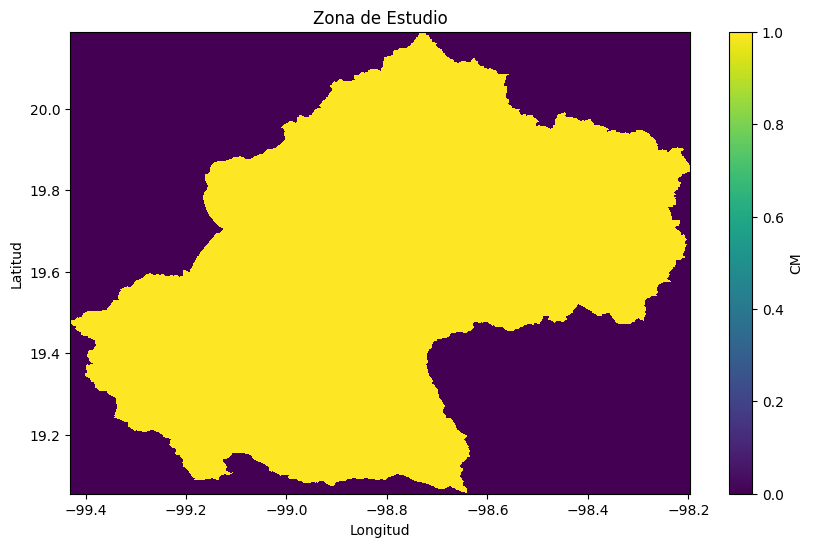

In [ ]:
# Graficar la variable 'CM'
acuifero_data =Poligon_ext['CM']
acuifero_data.plot( figsize=(10, 6))
plt.title('Zona de Estudio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

# GENERAR POLIGONO EXTERIOR Y POLIGONOS INTERNOS EN FORMATO .nc

In [21]:
# Unir todos los polígonos en un único polígono exterior
poligono_exterior = unary_union(gdf_Poligonos.geometry)

# Rasterizar el polígono exterior
rasterized_exterior = rasterize(
    [(poligono_exterior, 1)],  # Asignar 1 al polígono exterior
    out_shape=out_shape,
    transform=transform,
    fill=0,  # Ceros fuera del polígono
    dtype='int32'
)

# Crear el DataArray para el polígono exterior
da_cm = xr.DataArray(
    rasterized_exterior,
    dims=("lat", "lon"),
    coords={
        "lat": np.linspace(bounds[3], bounds[1], rasterized_exterior.shape[0]),
        "lon": np.linspace(bounds[0], bounds[2], rasterized_exterior.shape[1]),
    },
    name="CM"
)

# Crear un nuevo Dataset con la capa del polígono exterior
ds_all = xr.Dataset({"CM": da_cm})

# Agregar las capas de cada subpolígono (por clave)
for idx, clave in enumerate(gdf_Poligonos["CLAVE"]):
    clave_id = str(clave)  # Convertir clave a cadena
    mask = rasterized == (idx + 1)  # Crear una máscara para la clave actual
    ds_all[clave_id] = xr.DataArray(
        mask.astype(int),
        dims=("lat", "lon"),
        coords=da_cm.coords,
        name=clave_id
    )

In [23]:
# Guardar el archivo NetCDF
output_path = "/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/NetCDF_CM/Poligonos_int.nc"
ds_all.to_netcdf(output_path, format="NETCDF4")

In [24]:
#LEER XARRAY
Poligons_int = xr.open_dataset("/gdrive/My Drive/GitHub/RemoteSensing_DataAnalysis/NetCDF_CM/Poligonos_int.nc")
Poligons_int

<xarray.Dataset> Size: 84MB
Dimensions:  (lat: 1133, lon: 1233)
Coordinates:
  * lat      (lat) float64 9kB 20.19 20.19 20.19 20.19 ... 19.06 19.06 19.06
  * lon      (lon) float64 10kB -99.43 -99.43 -99.43 ... -98.2 -98.2 -98.2
Data variables:
    CM       (lat, lon) int32 6MB ...
    1507     (lat, lon) int64 11MB ...
    1319     (lat, lon) int64 11MB ...
    0901     (lat, lon) int64 11MB ...
    1320     (lat, lon) int64 11MB ...
    2902     (lat, lon) int64 11MB ...
    1506     (lat, lon) int64 11MB ...
    1508     (lat, lon) int64 11MB ...

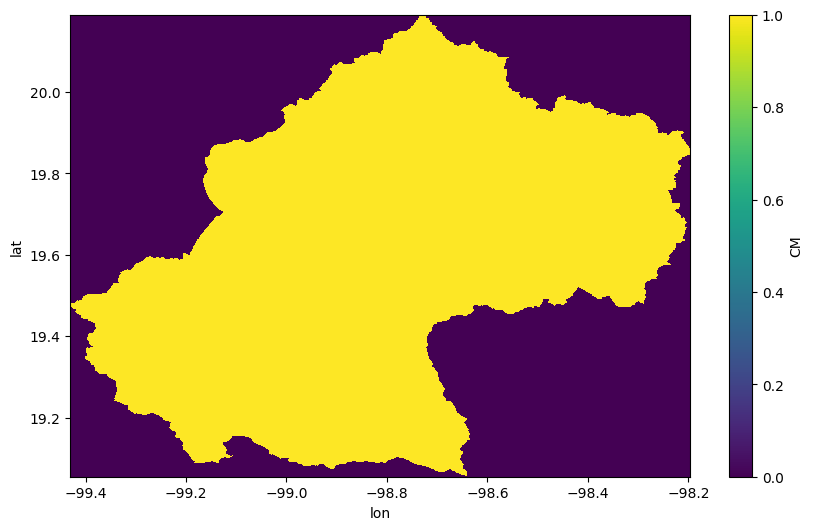

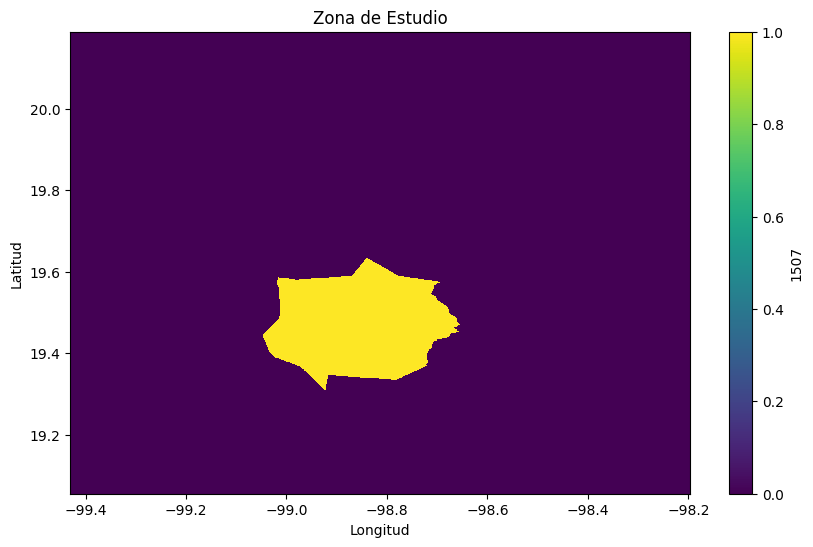

In [25]:
# Visualizar poligonos
poligono1 =Poligons_int['CM']
poligono2 =Poligons_int['1507']
poligono1.plot( figsize=(10, 6))
poligono2.plot( figsize=(10, 6))
plt.title('Zona de Estudio')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()